## Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

# Оглавление

1. [Открытие данных](#start)
2. [Предобработка данных](#preprocessing)
    * [Обработка пропущенных значений](#nul)
    * [Обработка дубликатов](#duplicates)
    * [Замена типа данных](#data_type)
    * [Лемматизация](#lemmatization)
    * [Категоризация](#categorization)
3. [Анализ данных](#analysis)
    * [Зависимость между наличием детей и возвратом кредита в срок](#children)
    * [Зависимость между семейным положением и возвратом кредита в срок](#family_status)
    * [зависимость между уровнем дохода и возвратом кредита в срок](#income)
    * [Зависимость между семейным положением и возвратом кредита в срок](#purpose)
4. [Общий вывод](#conclusion)

### Открытие данных <a id="start"></a>

In [163]:
import pandas as pd
from pymystem3 import Mystem
from collections import Counter
import pymorphy2

In [164]:
df = pd.read_csv('datasets/data.csv')

In [165]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


In [166]:
df.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


### Вывод

В файле 12 столбцов и 21525 строк. Данные трёх типов, строчные (object), натуральные числа (int64) и вещественные (float64). В странном виде представлены данные в колонке 'days_employed', очевидно, что количество дней не может быть представленно отрицательным вещественным числом. Те же вопросы к колонке 'total_income', цифры после точки неясно, что обозначают, точно не копейки, т.к. их больше чем две. Уже заметно, что некоторые данные нужно сделать более единообразными (например столбец 'education').

### Шаг 2. Предобработка данных <a id="preprocessing"></a>

### Обработка пропусков <a id="nul"></a>

In [167]:
#сначала посмотрим статистику по df
df.describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,21525.000000,19351.000000,21525.000000,21525.000000,21525.000000,21525.000000,1.935100e+04
mean,0.538908,63046.497661,43.293380,0.817236,0.972544,0.080883,1.674223e+05
std,1.381587,140827.311974,12.574584,0.548138,1.420324,0.272661,1.029716e+05
min,-1.000000,-18388.949901,0.000000,0.000000,0.000000,0.000000,2.066726e+04
25%,0.000000,-2747.423625,33.000000,1.000000,0.000000,0.000000,1.030532e+05
50%,0.000000,-1203.369529,42.000000,1.000000,0.000000,0.000000,1.450179e+05
75%,1.000000,-291.095954,53.000000,1.000000,1.000000,0.000000,2.034351e+05
max,20.000000,401755.400475,75.000000,4.000000,4.000000,1.000000,2.265604e+06


Обнаружились отрицательные значения там, где они не могут быть - в столбце _'children'_ с количеством детей и в столбце _'days_employed'_ с трудовым стажем в днях. Их надо исправить.

In [168]:
#преобразовываем все значения в их модуль
df['days_employed'] = df['days_employed'].abs()
df['total_income'] = df['total_income'].abs()
df['children'] = df['children'].abs()
df.describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,21525.000000,19351.000000,21525.000000,21525.000000,21525.000000,21525.000000,1.935100e+04
mean,0.543275,66914.728907,43.293380,0.817236,0.972544,0.080883,1.674223e+05
std,1.379876,139030.880527,12.574584,0.548138,1.420324,0.272661,1.029716e+05
min,0.000000,24.141633,0.000000,0.000000,0.000000,0.000000,2.066726e+04
25%,0.000000,927.009265,33.000000,1.000000,0.000000,0.000000,1.030532e+05
50%,0.000000,2194.220567,42.000000,1.000000,0.000000,0.000000,1.450179e+05
75%,1.000000,5537.882441,53.000000,1.000000,1.000000,0.000000,2.034351e+05
max,20.000000,401755.400475,75.000000,4.000000,4.000000,1.000000,2.265604e+06


Также надо поработать со столбцом _'total_income'_ - у него слишком длинная дробная часть, с которой неудобно работать. Округлим ежемесячные доходы клиентов.

In [169]:
df.head(5)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


In [170]:
df = df.round()
df.head(5)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8438.0,42,высшее,0,женат / замужем,0,F,сотрудник,0,253876.0,покупка жилья
1,1,4025.0,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.0,приобретение автомобиля
2,0,5623.0,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145886.0,покупка жилья
3,3,4125.0,32,среднее,1,женат / замужем,0,M,сотрудник,0,267629.0,дополнительное образование
4,0,340266.0,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.0,сыграть свадьбу


In [171]:
#проверим наличие None в таблице - таких значений не оказалось
df.isin(['None']).any()

children            False
days_employed       False
dob_years           False
education           False
education_id        False
family_status       False
family_status_id    False
gender              False
income_type         False
debt                False
total_income        False
purpose             False
dtype: bool

In [172]:
#посмотрим количество прcопусков по столбцам, проблемы с 'days_employed' и 'total_income'
df.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

У нас одинаковое количество пропущенных значений в колонках _'days_employed' и _'total_income'. Возможно, речь идёт об одних и тех же строках.

In [173]:
#при логической индексации 'или' мы находим ровно столько строк, сколько находится пустых значений в столбцах
df_with_nan = df.loc[(df['days_employed'].isna() == True) | (df['total_income'].isna() == True)]
df_with_nan

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
12,0,NaN,65,среднее,1,гражданский брак,1,M,пенсионер,0,NaN,сыграть свадьбу
26,0,NaN,41,среднее,1,женат / замужем,0,M,госслужащий,0,NaN,образование
29,0,NaN,63,среднее,1,Не женат / не замужем,4,F,пенсионер,0,NaN,строительство жилой недвижимости
41,0,NaN,50,среднее,1,женат / замужем,0,F,госслужащий,0,NaN,сделка с подержанным автомобилем
55,0,NaN,54,среднее,1,гражданский брак,1,F,пенсионер,1,NaN,сыграть свадьбу
...,...,...,...,...,...,...,...,...,...,...,...,...
21489,2,NaN,47,Среднее,1,женат / замужем,0,M,компаньон,0,NaN,сделка с автомобилем
21495,1,NaN,50,среднее,1,гражданский брак,1,F,сотрудник,0,NaN,свадьба
21497,0,NaN,48,ВЫСШЕЕ,0,женат / замужем,0,F,компаньон,0,NaN,строительство недвижимости
21502,1,NaN,42,среднее,1,женат / замужем,0,F,сотрудник,0,NaN,строительство жилой недвижимости


Изучим эти пропуски - посмотрим, обусловлены они чем-либо или это просто техническая ошибка

In [174]:
#сравним статистику по основному датасету и выборке с пропусками
df.describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,21525.000000,19351.000000,21525.000000,21525.000000,21525.000000,21525.000000,1.935100e+04
mean,0.543275,66914.727973,43.293380,0.817236,0.972544,0.080883,1.674223e+05
std,1.379876,139030.879631,12.574584,0.548138,1.420324,0.272661,1.029716e+05
min,0.000000,24.000000,0.000000,0.000000,0.000000,0.000000,2.066700e+04
25%,0.000000,927.000000,33.000000,1.000000,0.000000,0.000000,1.030530e+05
50%,0.000000,2194.000000,42.000000,1.000000,0.000000,0.000000,1.450180e+05
75%,1.000000,5538.000000,53.000000,1.000000,1.000000,0.000000,2.034350e+05
max,20.000000,401755.000000,75.000000,4.000000,4.000000,1.000000,2.265604e+06


In [175]:
df_with_nan.describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,2174.000000,0.0,2174.000000,2174.000000,2174.000000,2174.000000,0.0
mean,0.555198,NaN,43.632015,0.800828,0.975161,0.078197,NaN
std,1.468315,NaN,12.531481,0.530157,1.418220,0.268543,NaN
min,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,NaN
25%,0.000000,NaN,34.000000,0.250000,0.000000,0.000000,NaN
50%,0.000000,NaN,43.000000,1.000000,0.000000,0.000000,NaN
75%,1.000000,NaN,54.000000,1.000000,1.000000,0.000000,NaN
max,20.000000,NaN,73.000000,3.000000,4.000000,1.000000,NaN


Судя по тому, что статистики по обоим датасетам отличаются незначительно, вряд ли отсутствие значений в _days_employed_ и _total_income_ отображает какую-то особую категорию клиентов банка, скорее всего это просто ошибка при выгрузке. Можем заполнить их каким-то значением, например средним или медианой для каждого профессионального статуса.

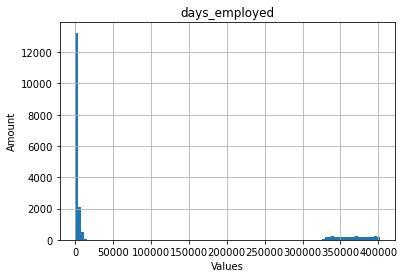

In [176]:
#смотрим распределение по колонке _'days_employed'_
hist_days_employed = df.hist(column='days_employed', bins=100)
for ax in hist_days_employed.flatten():
    ax.set_xlabel("Values")
    ax.set_ylabel("Amount")

In [177]:
hist_days_employed.flatten()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001B132150288>],
      dtype=object)

У данных странный хвост, который вряд ли может измеряться в днях (иначе получается, что люди работали несколько сотен лет). Видимо, эти данные подтягиваются некорректно. Таких значений немного, но они сильно влиюят на среднюю величину, поэтому берём для замены NaN медианное значение по столбцу. Учитывая, что далее эти данные не пригодятся для анализа, можно этим ограничиться.

In [178]:
df['days_employed'] = df['days_employed'].fillna(df['days_employed'].median())

In [179]:
#проверяем пропуски в days_employed - их не осталось
df.isna().sum()

children               0
days_employed          0
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

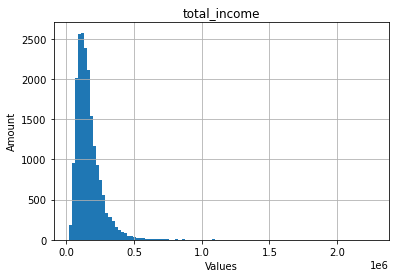

In [180]:
#гистограмма отображает доходы в -6 степени, т.е. 0.5 на графике - это доход в 500 тысяч рублей
hist_total_income = df.hist(column='total_income', bins=100)
for ax in hist_total_income.flatten():
    ax.set_xlabel("Values")
    ax.set_ylabel("Amount")

In [181]:
median_days_employed = df.groupby('income_type').agg({'total_income' : 'median'}) 
median_days_employed

,total_income
income_type,
безработный,131340.0
в декрете,53829.0
госслужащий,150448.0
компаньон,172358.0
пенсионер,118514.0
предприниматель,499163.0
сотрудник,142594.5
студент,98202.0


In [182]:
#заполним пропуски в 'total_income' медианами по уникальным значениям 'income_type'
for type_ in df['income_type'].unique():
    median = df.loc[df['income_type'] == type_, 'total_income'].median()
    print(type_, median)
    df.loc[(df['total_income'].isna()) & (df['income_type'] == type_), 'total_income'] = median

сотрудник 142594.5
пенсионер 118514.0
компаньон 172358.0
госслужащий 150448.0
безработный 131340.0
предприниматель 499163.0
студент 98202.0
в декрете 53829.0


In [183]:
#Пропусков не осталось
df.isna().sum()

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

### Вывод

Датасет оказался достаточно "чистым" относительно пропусков - пропущенные числовые значения были обнаружены лишь в двух столбцах в 10% данных, строк с None не оказалось. Судя по статистике, столбцы с пропусками не отличаются от основного датасета в значительной мере, данные могли отсутствовать по технической ошибке. Столбец _'days_employed'_ не играет большой роли для наших целей, поэтому пропуски были заполнены медианой по столбцу, в колонке _'total_income'_ они были заполнены медианой по типам занятости ('income_type').

### Замена типа данных <a id="data_type"></a>

In [184]:
# замените вещественный тип данных на целочисленный:
# поясните, как выбирали метод для изменения типа данных;

In [185]:
#вспомним, в каких столбцах у нас тип данных float
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     21525 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      21525 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


In [186]:
df['days_employed'] = df['days_employed'].astype('int64')

In [187]:
df['total_income'] = df['total_income'].astype('int64')

In [188]:
df.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8438,42,высшее,0,женат / замужем,0,F,сотрудник,0,253876,покупка жилья
1,1,4025,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля
2,0,5623,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145886,покупка жилья
3,3,4125,32,среднее,1,женат / замужем,0,M,сотрудник,0,267629,дополнительное образование
4,0,340266,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу


### Вывод

У нас было два столбца с вещественными числами - _'days_employed'_ и _'total_income'_. Чтобы перевести их в натуральный вид, с которым нам удобнее работать, выбираем метод 'astype', т.к. метод 'to_numeric' по умолчанию переводит значения во float. Теперь у нас все столбцы с числами приведены к одному формату.

### Обработка дубликатов <a id="duplicates"></a>

In [189]:
#посмотрим уникальные значения для каждой колонки
for column in df:
    print(f'{column}: {df[column].unique()}')

children: [ 1  0  3  2  4 20  5]
days_employed: [  8438   4025   5623 ... 362161 373996 343937]
dob_years: [42 36 33 32 53 27 43 50 35 41 40 65 54 56 26 48 24 21 57 67 28 63 62 47
 34 68 25 31 30 20 49 37 45 61 64 44 52 46 23 38 39 51  0 59 29 60 55 58
 71 22 73 66 69 19 72 70 74 75]
education: ['высшее' 'среднее' 'Среднее' 'СРЕДНЕЕ' 'ВЫСШЕЕ' 'неоконченное высшее'
 'начальное' 'Высшее' 'НЕОКОНЧЕННОЕ ВЫСШЕЕ' 'Неоконченное высшее'
 'НАЧАЛЬНОЕ' 'Начальное' 'Ученая степень' 'УЧЕНАЯ СТЕПЕНЬ'
 'ученая степень']
education_id: [0 1 2 3 4]
family_status: ['женат / замужем' 'гражданский брак' 'вдовец / вдова' 'в разводе'
 'Не женат / не замужем']
family_status_id: [0 1 2 3 4]
gender: ['F' 'M' 'XNA']
income_type: ['сотрудник' 'пенсионер' 'компаньон' 'госслужащий' 'безработный'
 'предприниматель' 'студент' 'в декрете']
debt: [0 1]
total_income: [253876 112080 145886 ...  89673 244093  82047]
purpose: ['покупка жилья' 'приобретение автомобиля' 'дополнительное образование'
 'сыграть свадьбу' 'операц

Дубликаты есть в поле _'education'_. Значения в разном регистре, возможно проблема была на этапе заполнения данных

In [190]:
#приводим к нижнему регистру значения в колонке 'education', уникальных значений теперь 5
df['education'] = df['education'].str.lower()
df['education'].unique()

array(['высшее', 'среднее', 'неоконченное высшее', 'начальное',
       'ученая степень'], dtype=object)

In [191]:
#для унификации данных сделаем то же самое в столбце 'family_status', где одно из значений начинается с заглавной буквы
df['family_status'] = df['family_status'].str.lower()
df['family_status'].unique()

array(['женат / замужем', 'гражданский брак', 'вдовец / вдова',
       'в разводе', 'не женат / не замужем'], dtype=object)

In [192]:
#посмотрим полные дубликаты среди строчек, их всего 71. 
df[df.duplicated()]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
2849,0,2194,41,среднее,1,женат / замужем,0,F,сотрудник,0,142594,покупка жилья для семьи
3290,0,2194,58,среднее,1,гражданский брак,1,F,пенсионер,0,118514,сыграть свадьбу
4182,1,2194,34,высшее,0,гражданский брак,1,F,сотрудник,0,142594,свадьба
4851,0,2194,60,среднее,1,гражданский брак,1,F,пенсионер,0,118514,свадьба
5557,0,2194,58,среднее,1,гражданский брак,1,F,пенсионер,0,118514,сыграть свадьбу
...,...,...,...,...,...,...,...,...,...,...,...,...
20702,0,2194,64,среднее,1,женат / замужем,0,F,пенсионер,0,118514,дополнительное образование
21032,0,2194,60,среднее,1,женат / замужем,0,F,пенсионер,0,118514,заняться образованием
21132,0,2194,47,среднее,1,женат / замужем,0,F,сотрудник,0,142594,ремонт жилью
21281,1,2194,30,высшее,0,женат / замужем,0,F,сотрудник,0,142594,покупка коммерческой недвижимости


Похоже, что это бывшие значения с пропусками, _'days_employed'_ и _'total_income'_ у них заполнены медианой, из-за этого вероятность совпадения таких людей в датасете выше (меньше различающихся значений)

In [193]:
#теперь удалим дубликаты
df = df.drop_duplicates().reset_index(drop=True)

In [194]:
#снова их проверяем, дубликатов больше нет
df[df.duplicated()]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose


In [195]:
len(df)

21454

### Вывод

Дубликаты были найдены в категориальных значениях в столбце _'education'_, что можно оказалось легко исправить приведением их к общему регистру. Дубликаты среди строк частично объясняются заполнением пропусков медианой, из-за чего возможность совпасть в значениях с другими строчками увеличилась. 

### Лемматизация <a id="lemmatization"></a>

In [196]:
#лемматизируем значения из столбца 'purpose' с помощью pymorphy (mystem в моём случае работал слишком долго)
morph = pymorphy2.MorphAnalyzer()
lemmatize_purpose = [morph.parse(purpose)[0].normal_form for purpose in df['purpose']]
len(lemmatize_purpose)

21454

In [197]:
#сравним длину датафрейма и получившегося столбца
len(df) == len(lemmatize_purpose)

True

In [198]:
df['lemmatized_purpose'] = lemmatize_purpose

In [199]:
#подсчитаем частотности сочетаний лемм и отсортируем по убыванию
freq_purposes = Counter(lemmatize_purpose)
freq_purposes.most_common()

[('автомобиль', 972),
 ('свадьба', 791),
 ('на проведение свадьба', 768),
 ('сыграть свадьба', 765),
 ('операции с недвижимость', 675),
 ('покупка коммерческой недвижимость', 661),
 ('операции с жилие', 652),
 ('покупка жилья для сдача', 651),
 ('операции с коммерческой недвижимость', 650),
 ('покупка жилие', 646),
 ('жильё', 646),
 ('покупка жилья для семья', 638),
 ('строительство собственной недвижимость', 635),
 ('недвижимость', 633),
 ('операции со своей недвижимость', 627),
 ('строительство жилой недвижимость', 624),
 ('покупка недвижимость', 621),
 ('покупка своего жилие', 620),
 ('строительство недвижимость', 619),
 ('ремонт жильё', 607),
 ('покупка жилой недвижимость', 606),
 ('на покупку своего автомобиль', 505),
 ('заняться высшим образование', 496),
 ('сделка с подержанным автомобиль', 486),
 ('на покупку подержанного автомобиль', 478),
 ('свой автомобиль', 478),
 ('на покупку автомобиль', 471),
 ('приобретение автомобиль', 461),
 ('дополнительное образование', 460),
 ('сде

In [200]:
#обобщим цели заёма до 4 групп - заём на автомобиль, свадьбу, образование и недвижимость, добавим этот столбец в датафрейм
general_purpose = []
for purpose in df.lemmatized_purpose:
    if 'автомобиль' in purpose:
        general_purpose.append('заём на автомобиль')
    elif 'образование' in purpose:
        general_purpose.append('заём на образование')
    elif 'свадьба' in purpose:
        general_purpose.append('заём на свадьбу')
    elif 'недвижимость' or 'жил' in purpose:
        general_purpose.append('заём на недвижимость')
df['general_purpose'] = general_purpose

In [201]:
#самая частотная цель кредита - операции с недвижимостью, больше половины кредитов
Counter(general_purpose).most_common()

[('заём на недвижимость', 10811),
 ('заём на автомобиль', 4306),
 ('заём на образование', 4013),
 ('заём на свадьбу', 2324)]

In [202]:
df.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,lemmatized_purpose,general_purpose
0,1,8438,42,высшее,0,женат / замужем,0,F,сотрудник,0,253876,покупка жилья,покупка жилие,заём на недвижимость
1,1,4025,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,приобретение автомобиль,заём на автомобиль
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145886,покупка жилья,покупка жилие,заём на недвижимость
3,3,4125,32,среднее,1,женат / замужем,0,M,сотрудник,0,267629,дополнительное образование,дополнительное образование,заём на образование
4,0,340266,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,сыграть свадьба,заём на свадьбу
5,0,926,27,высшее,0,гражданский брак,1,M,компаньон,0,255764,покупка жилья,покупка жилие,заём на недвижимость
6,0,2879,43,высшее,0,женат / замужем,0,F,компаньон,0,240526,операции с жильем,операции с жилие,заём на недвижимость
7,0,153,50,среднее,1,женат / замужем,0,M,сотрудник,0,135824,образование,образование,заём на образование
8,2,6930,35,высшее,0,гражданский брак,1,F,сотрудник,0,95857,на проведение свадьбы,на проведение свадьба,заём на свадьбу
9,0,2189,41,среднее,1,женат / замужем,0,M,сотрудник,0,144426,покупка жилья для семьи,покупка жилья для семья,заём на недвижимость


### Вывод

Мы лемматизировали столбец с целями кредита с помощью морфологического анализатора pymorphy2. Слову 'жильё' было приведено к разным начальным формам, поэтому искать его в списке целей впоследствии пришлось по стемме. Цели кредитов крутились в основном вокруг недвижимости, образования, свадьбы и автомобилей, поэтому они были обобщены; жильё, которое тоже часто встречалсь в категориях, было объединено с недвижимостью.Самой частотной группой оказались операции с недвижимостью, что можно объяснить её большей стоимостью по сравнению с расходами на другие цели.

### Категоризация данных <a id="categorization"></a>

In [203]:
#вспомним уникальный значения в столбце children
df.children.unique()

array([ 1,  0,  3,  2,  4, 20,  5], dtype=int64)

20 выглядит очевидным выбросом, хотя бы потому, что между ним и предыдущим значением слишком большая разница и нет промежуточных значений, надо убрать эти строки

In [204]:
df = df[df.children != 20]

In [205]:
df.children.unique()

array([1, 0, 3, 2, 4, 5], dtype=int64)

Напишем функции для категоризации по наличию детей и семейному положению

In [206]:
def categorize_children(row):
    children = row.children
    if children == 0:
        return 'бездетный клиент'
    elif children == 1:
        return 'клиент с 1 ребёнком'
    elif children == 2:
        return 'клиент с 2 детьми'
    else:
        return 'многодетный клиент'

In [207]:
#создадим столбец на основе написанной функции
df['categorized_children'] = df.apply(categorize_children, axis=1)

In [208]:
def categorize_family_status(row):
    status = row.family_status
    if status in ['женат / замужем', 'гражданский брак']:
        return 'в браке'
    else:
        return 'не в браке'

In [209]:
df['categorized_family_status'] = df.apply(categorize_family_status, axis=1)

Теперь разделим ежемесячные доходы клиентов на 4 квартиля и запишем это в колонку 'categorized_income'

In [210]:
df['categorized_income'] = pd.qcut(df['total_income'], 4, 
                                    labels=['I квартиль', 'II квартиль', 'III квартиль', 'IV квартиль'])

In [211]:
#проверим результат
df.head(20)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,lemmatized_purpose,general_purpose,categorized_children,categorized_family_status,categorized_income
0,1,8438,42,высшее,0,женат / замужем,0,F,сотрудник,0,253876,покупка жилья,покупка жилие,заём на недвижимость,клиент с 1 ребёнком,в браке,IV квартиль
1,1,4025,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,приобретение автомобиль,заём на автомобиль,клиент с 1 ребёнком,в браке,II квартиль
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145886,покупка жилья,покупка жилие,заём на недвижимость,бездетный клиент,в браке,III квартиль
3,3,4125,32,среднее,1,женат / замужем,0,M,сотрудник,0,267629,дополнительное образование,дополнительное образование,заём на образование,многодетный клиент,в браке,IV квартиль
4,0,340266,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,сыграть свадьба,заём на свадьбу,бездетный клиент,в браке,III квартиль
5,0,926,27,высшее,0,гражданский брак,1,M,компаньон,0,255764,покупка жилья,покупка жилие,заём на недвижимость,бездетный клиент,в браке,IV квартиль
6,0,2879,43,высшее,0,женат / замужем,0,F,компаньон,0,240526,операции с жильем,операции с жилие,заём на недвижимость,бездетный клиент,в браке,IV квартиль
7,0,153,50,среднее,1,женат / замужем,0,M,сотрудник,0,135824,образование,образование,заём на образование,бездетный клиент,в браке,II квартиль
8,2,6930,35,высшее,0,гражданский брак,1,F,сотрудник,0,95857,на проведение свадьбы,на проведение свадьба,заём на свадьбу,клиент с 2 детьми,в браке,I квартиль
9,0,2189,41,среднее,1,женат / замужем,0,M,сотрудник,0,144426,покупка жилья для семьи,покупка жилья для семья,заём на недвижимость,бездетный клиент,в браке,III квартиль


### Вывод

Мы категоризировали клиентов по трём колонкам, по которым в дальнейшем будет оцениваться их кредитоспособность - уровень дохода, наличие детей и семейное положение. Уровень дохода был присвоен в соответствии с квартелем, которые были взяты из метода 'df.describe', что гарантирует нам равномерное распределение клиентов по группам. По количеству детей семьи были разделены на бездетные, 1- и 2- детные, а также многодетные (от 3 детей и более), т.к. последних проще объединить в какую-то формализованную группу. Семейное положение разделено на людей в браке ('женат / замужем', 'гражданский брак') и остальных ('вдовец / вдова', 'в разводе', 'не женат / не замужем').

### Анализ данных <a id="analysis"></a>

- Есть ли зависимость между наличием детей и возвратом кредита в срок? <a id="children"></a>

Создадим функцию, которая в цикле проходит по уникальным значениям столбца, вставляет его в логическое условие, и по этой выборке ищет медиану или среднее по значениям второго столбца

In [212]:
def median_value_by_group(column1, column2):
    for value in column1.unique():
        print(f'{value}:', df.loc[column1 == value][column2].median())

In [213]:
def mean_value_by_group(column1, column2):
    for value in column1.unique():
        print(f'{value}:', df.loc[column1 == value][column2].mean())

In [214]:
#группируем по значениям категоризации и смотрим пропорцию возврата и невозврата кредита
df.groupby('categorized_children').debt.value_counts(normalize=True).map('{:.2%}'.format)

categorized_children  debt
бездетный клиент      0       92.46%
                      1        7.54%
клиент с 1 ребёнком   0       90.83%
                      1        9.17%
клиент с 2 детьми     0       90.55%
                      1        9.45%
многодетный клиент    0       91.84%
                      1        8.16%
Name: debt, dtype: object

In [215]:
#медианный возраст по клиентам, разбитых по категории наличия детей
median_value_by_group(df.categorized_children, 'dob_years')

клиент с 1 ребёнком: 38.0
бездетный клиент: 48.0
многодетный клиент: 36.0
клиент с 2 детьми: 35.0


In [216]:
#средний возраст по клиентам, разбитых по категории наличия детей
mean_value_by_group(df.categorized_children, 'dob_years')

клиент с 1 ребёнком: 38.41503604531411
бездетный клиент: 46.23213398623235
многодетный клиент: 36.32105263157895
клиент с 2 детьми: 35.769493177387915


In [217]:
#медианный доход клиентов, разбитых по категории наличия детей
median_value_by_group(df.categorized_children, 'total_income')

клиент с 1 ребёнком: 145522.0
бездетный клиент: 142594.0
многодетный клиент: 147204.0
клиент с 2 детьми: 142594.0


In [218]:
#средний доход клиентов, разбитых по категории наличия детей
mean_value_by_group(df.categorized_children, 'total_income')

клиент с 1 ребёнком: 169041.2403707518
бездетный клиент: 163052.58079625294
многодетный клиент: 177760.25789473683
клиент с 2 детьми: 169747.44444444444


In [219]:
#посмотрим распределение значений по датасету
df['categorized_children'].value_counts()

бездетный клиент       14091
клиент с 1 ребёнком     4855
клиент с 2 детьми       2052
многодетный клиент       380
Name: categorized_children, dtype: int64

In [220]:
df['categorized_children'].count()

21378

### Вывод

Первоначальная гипотеза предполагала, что среди многодетных клиентов будет больше всего должников, т.к. многодетные семьи обычно самые малообеспеченные. Но, как ни удивительно, процент должников среди них оказался ниже, чем у семей с одним или двумя детьми (8.16% против 9.17% и 9.45% соотвественно). С другой стороны, это можно объяснить малым размером выборки (многодетных клиентов всего 380 из 21378).

Самыми добросовестными клиентами оказались люди без детей, что вполне понятно - они меньше обремены дополнительными расходами. Можно было предположить, что это в основном молодые специалисты без семьи, ведь средние и медианные доходы этих людей оказались меньше доходов клиентов с детьми. Однако их возраст оказался выше, причем значительно (46 лет против 35-38 лет).

Можно сказать, что наличие детей у клиента в определённой степени влияет на влияет на возврат кредита в срок, разница в пользу бездетных достигает 1.5%-2%, а более высокий % у многодетных клиентов можно списать на их малое количество и нерепрезентативность.

- Есть ли зависимость между семейным положением и возвратом кредита в срок?  <a id="family_status"></a>

In [221]:
#группируем по значениям категоризации и смотрим пропорцию возврата и невозврата кредита
df.groupby('categorized_family_status').debt.value_counts(normalize=True).map('{:.2%}'.format)

categorized_family_status  debt
в браке                    0       92.01%
                           1        7.99%
не в браке                 0       91.51%
                           1        8.49%
Name: debt, dtype: object

In [222]:
#группируем по значениям категоризации и смотрим пропорцию возврата и невозврата кредита
df.groupby('family_status').debt.value_counts(normalize=True).map('{:.2%}'.format)

family_status          debt
в разводе              0       92.96%
                       1        7.04%
вдовец / вдова         0       93.40%
                       1        6.60%
гражданский брак       0       90.70%
                       1        9.30%
женат / замужем        0       92.45%
                       1        7.55%
не женат / не замужем  0       90.25%
                       1        9.75%
Name: debt, dtype: object

In [223]:
#посмотрим распределение значений по датасету
df['family_status'].value_counts()

женат / замужем          12290
гражданский брак          4139
не женат / не замужем     2801
в разводе                 1193
вдовец / вдова             955
Name: family_status, dtype: int64

In [224]:
mean_value_by_group(df.categorized_family_status, 'dob_years')

в браке: 43.1792561933167
не в браке: 43.59890887047889


In [225]:
#средний доход отличается несильно, но в браке он повыше
mean_value_by_group(df.categorized_family_status, 'total_income')

в браке: 166261.69340799804
не в браке: 162179.5172762174


In [226]:
df['categorized_family_status'].value_counts()

в браке       16429
не в браке     4949
Name: categorized_family_status, dtype: int64

In [227]:
#вдов/вдовцов наибольший средний возраст, у холостых - наименьший
mean_value_by_group(df.family_status, 'dob_years')

женат / замужем: 43.556631407648496
гражданский брак: 42.058709833293065
вдовец / вдова: 56.4848167539267
в разводе: 45.52388935456832
не женат / не замужем: 38.38557657979293


### Вывод

Статистика по категориям в браке/не в браке не даёт очевидного ответа - разница между группами всего 0.5% в пользу клиентов в браке.
Данные по графе 'family_status' показывают, что чаще кредит возвращают вдовцы/вдовы (93.4%), женатые люди (92.45%) и клиенты в разводе (92.96%). Меньше всего доля возвратов в срок у клиентов в гражданском браке (90.7%) и неженатых (90.25%).
Из этого можно предположить, что люди, имевшие опыт брака (даже уже расторгнутого) возвращают кредит кредит вовремя чаще, возможно из-за большей ответственности, которую предполагает этот статус, а также возможностью партнёра помочь с выплатами.
Люди, не вступившие в брак или сожительствующие, возможно менее ответсвенные и имеют меньше возможностей получить финансовую поддержку от партнёра.

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок? <a id="income"></a>

In [228]:
#группируем по значениям категоризации и смотрим пропорцию возврата и невозврата кредита
df.groupby('categorized_income').debt.value_counts(normalize=True).map('{:.2%}'.format)

categorized_income  debt
I квартиль          0       92.01%
                    1        7.99%
II квартиль         0       91.21%
                    1        8.79%
III квартиль        0       91.49%
                    1        8.51%
IV квартиль         0       92.87%
                    1        7.13%
Name: debt, dtype: object

In [229]:
median_value_by_group(df.categorized_income, 'dob_years')

IV квартиль: 42.0
II квартиль: 43.0
III квартиль: 41.0
I квартиль: 45.0


### Вывод

В этом случае сложно сделать какой-то однозначный вывод, мы не можем проследить линейную зависимость между величиной дохода и вероятностью вернуть кредит в срок. Самый большой % возврата у клиенктов с низкими доходами (I квартиль, 92.01%) и самыми высокими доходами (IV квартиль, 92.87%). Серединные значения "провисают" (91.21% и 91.49%).
В целом, у людей с наивысшими доходами несколько больше вероятность вернуть кредит в срок, но и не надо ставить крест на людях с невысокими доходами.

- Как разные цели кредита влияют на его возврат в срок? <a id="purpose"></a>

In [230]:
#группируем по значениям категоризации и смотрим пропорцию возврата и невозврата кредита
df.groupby('general_purpose').debt.value_counts(normalize=True).map('{:.2%}'.format)

general_purpose       debt
заём на автомобиль    0       90.65%
                      1        9.35%
заём на недвижимость  0       92.76%
                      1        7.24%
заём на образование   0       90.77%
                      1        9.23%
заём на свадьбу       0       92.10%
                      1        7.90%
Name: debt, dtype: object

In [231]:
#посмотрим распределение значений по датасету
df['general_purpose'].value_counts()

заём на недвижимость    10775
заём на автомобиль       4290
заём на образование      3998
заём на свадьбу          2315
Name: general_purpose, dtype: int64

In [232]:
#возраст значительно не отличается
median_value_by_group(df.general_purpose, 'dob_years')

заём на недвижимость: 42.0
заём на автомобиль: 43.0
заём на образование: 42.0
заём на свадьбу: 42.0


In [233]:
#доход тоже
median_value_by_group(df.general_purpose, 'total_income')

заём на недвижимость: 142949.0
заём на автомобиль: 142594.0
заём на образование: 142594.0
заём на свадьбу: 142594.0


### Вывод

Наибольшей "возвращаемостью" обладают кредиты на недвижимость (92.76%) и заёмы на свадьбу (92.1%). В первом случае дело может в том, что ипотечные кредиты берут люди, уже уверенные в своих будущих доходах и имеющие достаточно средств на первый взнос. Также неоплата ипотеки чревата более серьёзными последствиями (потеря жилья), нежели другие кредиты, поэтому к их выплате клиенты относятся более ответственно.
Более частый возврат заёмов на свадьбу можно объяснить их изначальной не очень высокой суммой (несколько сотен тысяч рублей), а также их быстрый возврат засчёт подарков гостей.
Более низкий процент возврата кредитов на образование и автомобили может быть из-за более щадящих условий возврата (в случае кредита на образование); автомобиль имеет не является жизненнонеобходимым приобретением, поэтому возврат кредита за него может не быть в первом приоритете. 

### Общий вывод <a id="conclusion"></a>

Мы можем утверждать, что наличие детей и семейное положение влияют на вероятность возврата кредита. Вероятность вернуть кредит у бездетных клиентов выше, нежели у клиентов с 1 или 2 детьми (насчёт многодетных семей по имеющимся данным утверждать однозначно мы не можем). Также люди с опытом официально оформленного брака имеют лучшую статистику по возврату кредита банку по сравнению холостыми клиентами или состоящих в гражданском браке.
Говоря о влиянии целей кредита на его возврат, мы можем с большей уверенностью полагать, что заём на недвижимость и свадьбу вернётся с большей гарантией, чем на кредит на образование или автомобиль. Воздействие уровня доходов клиента на возврат займа можно заметить у группы с самыми высокими доходами, про остальные группы сказать однозначно сложно. 